In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# env = gym.make('InvertedPendulum-v4', render_mode="human")

In [3]:
# # while True:
# state = env.reset()[0]
# for i in range(1000):
#     action = np.array([0.001])
#     env.step(action)

In [4]:
# dir(env.action_space)

In [5]:
# env.action_space.shape

In [6]:
# dir(env.action_space)

Verdict: The real issue is that it's getting terminated. Probably, because it's not performing well enough (or the termination criterion is too strict).

In [7]:
env = gym.make('InvertedPendulum-v5')

In [8]:
# ACTION_SPACE_DISCRETIZATION_SIZE = 10
ACTION_SPACE_DISCRETIZATION_SIZE = 3

In [9]:
def termination_condition(is_training, terminated, rewards):
    if is_training: return not terminated and rewards < 10000
    # else: return not terminated and rewards < 10000*100
    # else: return not terminated
    else: return True

def run(is_training=True, render=False):
    # is_training = True; render = False;

    # env = gym.make('InvertedPendulum-v4', render_mode='human' if render else None)
    env = gym.make('InvertedPendulum-v5', render_mode='human' if render else None)

    # Divide position, velocity, pole angle, and pole angular velocity into segments
    pos_space = np.linspace(-2.4, 2.4, 10)
    vel_space = np.linspace(-4, 4, 10)
    ang_space = np.linspace(-.2095, .2095, 10)
    ang_vel_space = np.linspace(-4, 4, 10)
    action_space = np.linspace(env.action_space.low[0], env.action_space.high[0], ACTION_SPACE_DISCRETIZATION_SIZE)

    if(is_training):
        q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(ang_space)+1, len(ang_vel_space)+1, len(action_space)+1)) # init a 11x11x11x11x2 array
    else:
        f = open('cartpole.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.1 # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount factor.

    epsilon = 1         # 1 = 100% random actions
    # epsilon_decay_rate = 0.00001 # epsilon decay rate
    epsilon_decay_rate = 0.000001 # epsilon decay rate (10x slower)
    # epsilon_decay_rate = 0.0000001 # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = []

    i = 0

    # for i in range(episodes):
    while(True):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        state_a = np.digitize(state[2], ang_space)
        state_av = np.digitize(state[3], ang_vel_space)

        terminated = False          # True when reached goal

        rewards=0

        # while(not terminated and rewards < 10000):
        while(termination_condition(is_training, terminated, rewards)): # CHANGED
        # while(True): # CHANGED

            if is_training and rng.random() < epsilon:
                # Choose random action  (0=go left, 1=go right)
                # action = env.action_space.sample()
                # action = np.digitize(env.action_space.sample(), action_space)
                action = np.digitize(env.action_space.sample(), action_space)[0]
                action_1 = action
            else:
                action = np.argmax(q[state_p, state_v, state_a, state_av, :])
                action_2 = action
                # print("ARGMAXING")

            # print("action:", round(action_space[action], 2))
            # new_state,reward,terminated,_,_ = env.step(action)
            # new_state,reward,terminated,_,_ = env.step(np.array(action))
            # new_state,reward,terminated,_,_ = env.step(np.array(action, dtype=np.float32))
            # new_state,reward,terminated,_,_ = env.step([0.0])
            # new_state,reward,terminated,_,_ = env.step([action]) # didn't work (at all)
            new_state,reward,terminated,_,_ = env.step([action_space[action]])
            # new_state,reward,terminated,_,_ = env.step([action[0]]) # NOTE dunno why this works. figure it out
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            new_state_a = np.digitize(new_state[2], ang_space)
            new_state_av= np.digitize(new_state[3], ang_vel_space)

            if is_training:
                q[state_p, state_v, state_a, state_av, action] = q[state_p, state_v, state_a, state_av, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - q[state_p, state_v, state_a, state_av, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av= new_state_av

            rewards+=reward

            if not is_training and rewards%100==0:
                print(f'Episode: {i}  Rewards: {rewards}')

        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])

        if is_training and i%100==0:
            print(f'Episode: {i} {rewards}  Epsilon: {epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')

        if mean_rewards>1000:
        # if mean_rewards>2.9: # CHANGED
            if is_training: 
                break

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if epsilon == 0: break # consider training done.

        i+=1


    env.close()

    # Save Q table to file
    if is_training:
        f = open('cartpole.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = []
    for t in range(i):
        mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
    plt.plot(mean_rewards)
    plt.savefig(f'cartpole.png')

Episode: 0 2  Epsilon: 1.00  Mean Rewards 2.0
Episode: 100 2  Epsilon: 1.00  Mean Rewards 3.2
Episode: 200 2  Epsilon: 1.00  Mean Rewards 2.9
Episode: 300 3  Epsilon: 1.00  Mean Rewards 3.2
Episode: 400 2  Epsilon: 1.00  Mean Rewards 3.1
Episode: 500 2  Epsilon: 1.00  Mean Rewards 2.9
Episode: 600 3  Epsilon: 1.00  Mean Rewards 2.8
Episode: 700 2  Epsilon: 1.00  Mean Rewards 2.9
Episode: 800 4  Epsilon: 1.00  Mean Rewards 2.9
Episode: 900 4  Epsilon: 1.00  Mean Rewards 3.1
Episode: 1000 2  Epsilon: 1.00  Mean Rewards 2.9
Episode: 1100 2  Epsilon: 1.00  Mean Rewards 2.8
Episode: 1200 2  Epsilon: 1.00  Mean Rewards 3.2
Episode: 1300 3  Epsilon: 1.00  Mean Rewards 2.9
Episode: 1400 2  Epsilon: 1.00  Mean Rewards 3.5
Episode: 1500 4  Epsilon: 1.00  Mean Rewards 3.3
Episode: 1600 5  Epsilon: 1.00  Mean Rewards 3.3
Episode: 1700 2  Epsilon: 1.00  Mean Rewards 2.8
Episode: 1800 7  Epsilon: 1.00  Mean Rewards 3.2
Episode: 1900 4  Epsilon: 1.00  Mean Rewards 3.0
Episode: 2000 3  Epsilon: 1.00  

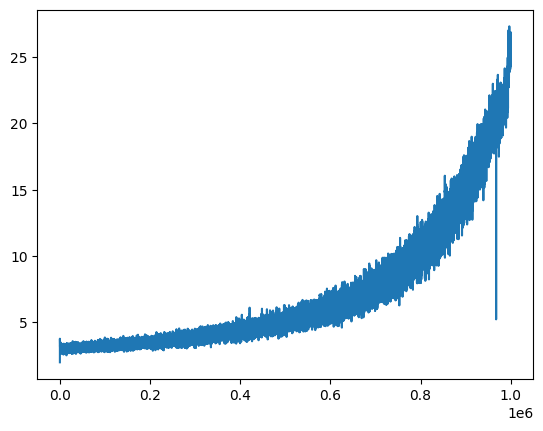

In [10]:
run(is_training=True, render=False)

In [13]:
run(is_training=False, render=True)

Exception ignored on calling ctypes callback function: <function _handle_glfw_errors at 0x12e630900>
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/glfw/__init__.py", line 659, in callback_wrapper
    @functools.wraps(func)

KeyboardInterrupt: 


## References

### Example Q-Learning Code for Cartpole in Gymnasium-Classical

```Python
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(is_training=True, render=False):

    env = gym.make('CartPole-v1', render_mode='human' if render else None)

    # Divide position, velocity, pole angle, and pole angular velocity into segments
    pos_space = np.linspace(-2.4, 2.4, 10)
    vel_space = np.linspace(-4, 4, 10)
    ang_space = np.linspace(-.2095, .2095, 10)
    ang_vel_space = np.linspace(-4, 4, 10)

    if(is_training):
        q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(ang_space)+1, len(ang_vel_space)+1, env.action_space.n)) # init a 11x11x11x11x2 array
    else:
        f = open('cartpole.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.1 # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount factor.

    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 0.00001 # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = []

    i = 0

    # for i in range(episodes):
    while(True):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        state_a = np.digitize(state[2], ang_space)
        state_av = np.digitize(state[3], ang_vel_space)

        terminated = False          # True when reached goal

        rewards=0

        while(not terminated and rewards < 10000):

            if is_training and rng.random() < epsilon:
                # Choose random action  (0=go left, 1=go right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, state_a, state_av, :])

            new_state,reward,terminated,_,_ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            new_state_a = np.digitize(new_state[2], ang_space)
            new_state_av= np.digitize(new_state[3], ang_vel_space)

            if is_training:
                q[state_p, state_v, state_a, state_av, action] = q[state_p, state_v, state_a, state_av, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - q[state_p, state_v, state_a, state_av, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av= new_state_av

            rewards+=reward

            if not is_training and rewards%100==0:
                print(f'Episode: {i}  Rewards: {rewards}')

        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])

        if is_training and i%100==0:
            print(f'Episode: {i} {rewards}  Epsilon: {epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')

        if mean_rewards>1000:
            break

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        i+=1

    env.close()

    # Save Q table to file
    if is_training:
        f = open('cartpole.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = []
    for t in range(i):
        mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
    plt.plot(mean_rewards)
    plt.savefig(f'cartpole.png')

if __name__ == '__main__':
    # run(is_training=True, render=False)

    run(is_training=False, render=True)
```